In [2]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import SpikeTrain, TuningCurve, NeuralTrajectory
from mazepy.datastruc.variables import VariableBin

code_id = "0842 - Kmeans Clustering (Lisa Paper)"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

def low_rank_factorization(X, rank_R, k_clusters):
    """
    Performs low-rank matrix factorization with a k-means constraint.

    Parameters:
        X: ndarray (I x J x K) tensor of normalized firing rates
        rank_R: int, rank for the truncated factorization
        k_clusters: int, number of clusters (for k-means constraint)

    Returns:
        U: ndarray, binary clustering assignment (I x R)
        V: ndarray, low-dimensional factors (R x JK)
    """
    # Step 1: Reshape the tensor X into a 2D matrix (I x JK)
    I, J, K = X.shape
    X_reshaped = X.reshape(I, -1)

    # Step 2: Perform truncated SVD for rank-R decomposition
    svd = TruncatedSVD(n_components=rank_R, random_state=42)
    U_continuous = svd.fit_transform(X_reshaped)  # U is continuous
    V = svd.components_  # V shape: (R, JK)

    # Step 3: Apply k-means clustering to enforce binary constraints on U
    kmeans = KMeans(n_clusters=k_clusters, random_state=42)
    U_clusters = kmeans.fit_predict(U_continuous)

    # Reconstruct the matrix using the low-rank representation
    X_reconstructed = np.dot(U_continuous, V)
    
    # Compute the Residual Sum of Squares (RSS)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    RSS = np.sum([np.linalg.norm(U_continuous[i, :] - cluster_centers[labels[i]]) ** 2 for i in range(U_continuous.shape[0])])  
    
    # Step 4: Calculate per-point distances to their respective cluster centers
    distances = np.linalg.norm(U_continuous - cluster_centers[U_clusters], axis=1).reshape(-1, 1)

    # Step 5: Map cluster assignments to 1 (map1) and -1 (map2)
    U_clusters_binary = np.where(U_clusters == 0, 1, -1)

    # Step 6: Return results
    return distances, V, U_continuous, U_clusters_binary, RSS 

def get_lap_distances(X, V):
    """
    Refer to 'Distance to cluster calculations' Section of Lisa paper.
    
    Parameters
    ----------
    X: ndarray (I x J x K) tensor of normalized firing rates
        I: Trials/Laps
        J: Position Bins
        K: Neurons
    V: ndarray, low-dimensional factors (R x JK)
        R: Rank, which is 2 here
    
    Returns
    -------
    Distances: ndarray, distances to cluster centers (I x R), for each position
    in each lap.
    """
    I, J, K = X.shape
    V = V.reshape(2, J, K)
    
    Distances = np.zeros(I)
    
    for i in range(I):
        Distances[i] = (
            np.sum(
                (2 * X[i, :, :] - (V[0, :, :] + V[1, :, :])) * 
                (V[0, :, :] - V[1, :, :])
            ) / 
            np.sum((V[0, :, :] - V[1, :, :])**2)
        )
            
    return Distances

def get_lap_neuron_distances(X, V):
    """
    Refer to 'Distance to cluster calculations' Section of Lisa paper.
    
    Parameters
    ----------
    X: ndarray (I x J x K) tensor of normalized firing rates
        I: Trials/Laps
        J: Position Bins
        K: Neurons
    V: ndarray, low-dimensional factors (R x JK)
        R: Rank, which is 2 here
    
    Returns
    -------
    Distances: ndarray, distances to cluster centers (I x R), for each neuron
    in each lap.
    and 
    """
    I, J, K = X.shape
    V = V.reshape(2, J, K)
    
    Distances = np.zeros((I, K))
    
    for i in range(I):
        for k in range(K):
            Distances[i, k] = (
                np.sum(
                    (2 * X[i, :, k] - (V[0, :, k] + V[1, :, k])) * 
                    (V[0, :, k] - V[1, :, k])
                ) / 
                np.sum((V[0, :, k] - V[1, :, k])**2)
            )
            
    return Distances

def get_lap_pos_distances(X, V):
    """
    Refer to 'Distance to cluster calculations' Section of Lisa paper.
    
    Parameters
    ----------
    X: ndarray (I x J x K) tensor of normalized firing rates
        I: Trials/Laps
        J: Position Bins
        K: Neurons
    V: ndarray, low-dimensional factors (R x JK)
        R: Rank, which is 2 here
    
    Returns
    -------
    Distances: ndarray, distances to cluster centers (I x R), for each position
    in each lap.
    """
    I, J, K = X.shape
    V = V.reshape(2, J, K)
    
    Distances = np.zeros((I, J))
    
    for i in range(I):
        for j in range(J):
            Distances[i, j] = (
                np.sum(
                    (2 * X[i, j, :] - (V[0, j, :] + V[1, j, :])) * 
                    (V[0, j, :] - V[1, j, :])
                ) / 
                np.sum((V[0, j, :] - V[1, j, :])**2)
            )
            
    return Distances

def get_lapwise_ratemap(trace: dict):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    smoothed_map = np.zeros((trace['n_neuron'], 144, beg_idx.shape[0]), dtype = np.float64)
    
    print(np.unique(routes))
    
    for i in tqdm(range(beg_idx.shape[0])):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = spike_nodes_transform(trace['spike_nodes_original'][spike_idx].astype(np.int64), 12)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        rate_map = spike_train.calc_tuning_curve(144, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() #@ trace['Ms'].T
    
    return smoothed_map

def select_best_rank(X, k_clusters, max_rank):
    """
    Uses BIC to select the best rank R for low-rank matrix factorization.

    Parameters:
        X: ndarray (I x J x K) tensor of normalized firing rates
        k_clusters: int, number of clusters
        max_rank: int, maximum rank R to test

    Returns:
        best_R: int, the rank R with the lowest RSS score
        RSS_scores: list, RSS scores for each tested rank
    """
    I, J, K = X.shape
    n = I  # Number of samples (rows in U_continuous)
    BIC_scores = []
    RSSs = []

    for rank_R in range(1, max_rank + 1):
        # Perform low-rank factorization
        distances, V, U_continuous, _, RSS = low_rank_factorization(X, rank_R, rank_R)

        # Compute BIC score
        m = d = rank_R
        k = m * d + (m - 1)
        BIC = n * np.log(RSS / n) + k * np.log(n)
        BIC_scores.append(BIC)
        RSSs.append(RSS)

    # Select the rank with the lowest BIC
    best_R = np.argmin(BIC_scores) + 1  # +1 because rank starts from 1
    return np.array(BIC_scores)

# Example Usage
# Generate synthetic tensor X (I x J x K)
I, J, K = 100, 10, 12  # Example dimensions
rank_R = 2             # Number of components
k_clusters = 3       # Number of clusters

# Simulated normalized firing rates
np.random.seed(42)
X = np.random.rand(I, J, K)

# Factorization with constraints
dist_score, V, U, _, _ = low_rank_factorization(X, rank_R, k_clusters)
print(U.shape, V.shape)
#print("U (binary clustering assignments):\n", U)
#print("V (low-rank factors):\n", V)

        E:\Data\FinalResults\Dsp\0842 - Kmeans Clustering (Lisa Paper) is already existed!
(100, 2) (2, 120)


e:\Anaconda\envs\maze\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [21]:
if os.path.exists(join(figdata, code_id+'.pkl')) == False:
    Data = {
        "MiceID": [],
        "Training Day": [],
        "File Index": [],
        "Lap": [],
        "Distance": [],
        "Routes": [],
        "Dist_Score": [],
        "Binary Map": []
    }
    
    for i in np.where(f2['MiceID'] != 10209)[0]:
        print(f"{i}, {f2['MiceID'][i]}, {f2['training_day'][i]}")
        
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
            
        bins = CP_DSP[3]-1
        #bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])-1
        smoothed_map = get_lapwise_ratemap(trace)[:, bins, :]

        X = smoothed_map = np.transpose(smoothed_map, axes=[2, 1, 0])
        I, J, K = smoothed_map.shape
        
        beg, end = LapSplit(trace, trace['paradigm'])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)

        # Example Usage
        # Generate synthetic tensor X (I x J x K)
        #I, J, K = 100, 10, 12  # Example dimensions
        rank_R = 2             # Number of components
        k_clusters = 2         # Number of clusters
        
        # Factorization with constraints
        dist_score, V, U, UB, _ = low_rank_factorization(X, rank_R, k_clusters)
        print(dist_score.shape)
        
        Data['MiceID'].append(np.repeat(int(f2['MiceID'][i]), U.shape[0]))
        Data['Training Day'].append(np.repeat(f2['training_day'][i], U.shape[0]))
        Data['File Index'].append(np.repeat(i, U.shape[0]))
        Data['Lap'].append(np.arange(U.shape[0]))
        Data['Distance'].append(U[:, 0])
        Data['Dist_Score'].append(dist_score[:, 0])
        Data['Routes'].append(routes)
        Data['Binary Map'].append(UB)
        
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
    
    with open(join(figdata, code_id+'.pkl'), 'wb') as handle:
        pickle.dump(Data, handle)
        
    print(Data['Distance'].shape)
    
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, code_id+'.xlsx'), index=False)
else:
    with open(join(figdata, code_id+'.pkl'), 'rb') as handle:
        Data = pickle.load(handle)
        
if exists(join(figdata, code_id+' [RSS].pkl')) == False:
    RSSData = {
        "MiceID": [],
        "Training Day": [],
        "File Index": [],
        "X": [],
        "BIC": []
    }
    for i in np.where(f2['MiceID'] != 10209)[0]:
        print(f"{i}, {f2['MiceID'][i]}, {f2['training_day'][i]}")
        
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
            
        bins = CP_DSP[3]-1
        #bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])-1
        smoothed_map = get_lapwise_ratemap(trace)[:, bins, :]
        smoothed_map[np.isnan(smoothed_map)] = 0
        smoothed_map[np.isinf(smoothed_map)] = 0
        for k in range(smoothed_map.shape[0]):
            vmin, vmax = np.nanmin(smoothed_map[k, :, :]), np.nanmax(smoothed_map[k, :, :])
            if vmin == vmax:
                continue
            smoothed_map[k, :, :] = (smoothed_map[k, :, :] - vmin) / (vmax - vmin)

        X = smoothed_map = np.transpose(smoothed_map, axes=[2, 1, 0])
        I, J, K = smoothed_map.shape
        
        beg, end = LapSplit(trace, trace['paradigm'])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)
        
        RSS = select_best_rank(X, 2, 5)
        
        RSSData['MiceID'].append(np.repeat(int(f2['MiceID'][i]), RSS.shape[0]))
        RSSData['Training Day'].append(np.repeat(f2['training_day'][i], RSS.shape[0]))
        RSSData['File Index'].append(np.repeat(i, RSS.shape[0]))
        RSSData['X'].append(np.arange(1, 6))
        RSSData['BIC'].append(RSS)
        
    for k in RSSData.keys():
        RSSData[k] = np.concatenate(RSSData[k])
    
    with open(join(figdata, code_id+' [RSS].pkl'), 'wb') as handle:
        pickle.dump(RSSData, handle)
        
    print(RSSData['BIC'].shape)
    
    RSSD = pd.DataFrame(Data)
    RSSD.to_excel(join(figdata, code_id+' [RSS].xlsx'), index=False)
else:
    with open(join(figdata, code_id+' [RSS].pkl'), 'rb') as handle:
        RSSData = pickle.load(handle)

1, 10212, Day 1
[0 1 2 3 4 5 6]


  0%|          | 0/52 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 52/52 [00:00<00:00, 182.05it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(52, 1)
3, 10212, Day 2
[0 1 2 3 4 5 6]


  0%|          | 0/60 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 60/60 [00:00<00:00, 248.73it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(60, 1)
5, 10212, Day 3
[0 1 2 3 4 5 6]


  0%|          | 0/74 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 74/74 [00:00<00:00, 331.06it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(74, 1)
7, 10212, Day 4
[0 1 2 3 4 5 6]


  0%|          | 0/82 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 82/82 [00:00<00:00, 244.34it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(82, 1)
9, 10212, Day 5
[0 1 2 3 4 5 6]


  0%|          | 0/80 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 80/80 [00:00<00:00, 299.34it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(80, 1)
11, 10212, Day 6
[0 1 2 3 4 5 6]


  0%|          | 0/101 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 101/101 [00:00<00:00, 238.20it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(101, 1)
13, 10212, Day 7
[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:00<00:00, 234.28it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(100, 1)
14, 10224, Day 1
[0 1 2 3 4 5 6]


  0%|          | 0/89 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 89/89 [00:00<00:00, 153.24it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(89, 1)
15, 10227, Day 1
[0 1 2 3 4 5 6]


  0%|          | 0/68 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 68/68 [00:00<00:00, 78.33it/s] 
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(68, 1)
16, 10224, Day 2
[0 1 2 3 4 5 6]


  0%|          | 0/92 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 92/92 [00:00<00:00, 179.92it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(92, 1)
17, 10227, Day 2
[0 1 2 3 4 5 6]


  0%|          | 0/88 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 88/88 [00:01<00:00, 87.02it/s] 
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(88, 1)
18, 10224, Day 3
[0 1 2 3 4 5 6]


  0%|          | 0/89 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 89/89 [00:00<00:00, 197.78it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(89, 1)
19, 10227, Day 3
[0 1 2 3 4 5 6]


  0%|          | 0/83 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 83/83 [00:00<00:00, 114.97it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(83, 1)
20, 10224, Day 4
[0 1 2 3 4 5 6]


  0%|          | 0/97 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 97/97 [00:00<00:00, 195.09it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(97, 1)
21, 10227, Day 4
[0 1 2 3 4 5 6]


  0%|          | 0/93 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 93/93 [00:00<00:00, 124.36it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(93, 1)
22, 10224, Day 5
[0 1 2 3 4 5 6]


  0%|          | 0/99 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 99/99 [00:00<00:00, 189.03it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(99, 1)
23, 10227, Day 5
[0 1 2 3 4 5 6]


  0%|          | 0/92 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 92/92 [00:00<00:00, 110.55it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(92, 1)
24, 10224, Day 6
[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:00<00:00, 165.83it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(100, 1)
25, 10227, Day 6
[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:00<00:00, 129.94it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(100, 1)
26, 10224, Day 7
[0 1 2 3 4 5 6]


  0%|          | 0/101 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 101/101 [00:00<00:00, 155.69it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(101, 1)
27, 10227, Day 7
[0 1 2 3 4 5 6]


  0%|          | 0/95 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 95/95 [00:00<00:00, 120.32it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(95, 1)
28, 10232, Day 1
[0 1 2 3 4 5 6]


  0%|          | 0/99 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 99/99 [00:01<00:00, 85.48it/s] 
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(99, 1)
29, 10232, Day 2
[0 1 2 3 4 5 6]


  0%|          | 0/102 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 102/102 [00:00<00:00, 141.02it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(102, 1)
30, 10232, Day 3
[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:00<00:00, 165.27it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(100, 1)
31, 10232, Day 4
[0 1 2 3 4 5 6]


  0%|          | 0/108 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 108/108 [00:00<00:00, 195.61it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(108, 1)
32, 10232, Day 5
[0 1 2 3 4 5 6]


  0%|          | 0/117 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 117/117 [00:00<00:00, 129.24it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(117, 1)
33, 10232, Day 6
[0 1 2 3 4 5 6]


  0%|          | 0/120 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 120/120 [00:00<00:00, 171.57it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(120, 1)
34, 10232, Day 7
[0 1 2 3 4 5 6]


  0%|          | 0/130 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 130/130 [00:00<00:00, 271.00it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(130, 1)
(2611,)


In [7]:
def hex_to_rgba(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-255).
    """
    hex_color = hex_color.lstrip('#')  # Remove '#' if present
    if len(hex_color) == 6:
        r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
        a = 255  # Default alpha
    elif len(hex_color) == 8:
        r, g, b, a = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16), int(hex_color[6:8], 16)
    else:
        raise ValueError("Invalid hex color format. Use #RRGGBB or #RRGGBBAA.")
    return r, g, b, a

def hex_to_rgba_normalized(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-1).
    """
    r, g, b, a = hex_to_rgba(hex_color)
    return np.array([r / 255, g / 255, b / 255, a / 255])

DSPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in DSPPalette])
MAPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in ['#333766', '#A4C096']])

# Lapwise Neuronal Distances

1, 10212, Day 1
[0 1 2 3 4 5 6]


  0%|          | 0/52 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 52/52 [00:00<00:00, 183.74it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 2845
3, 10212, Day 2
[0 1 2 3 4 5 6]


  0%|          | 0/60 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 60/60 [00:00<00:00, 409.61it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 3060
5, 10212, Day 3
[0 1 2 3 4 5 6]


  0%|          | 0/74 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 74/74 [00:00<00:00, 436.05it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 4070
7, 10212, Day 4
[0 1 2 3 4 5 6]


  0%|          | 0/82 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 82/82 [00:00<00:00, 450.68it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 4154
9, 10212, Day 5
[0 1 2 3 4 5 6]


  0%|          | 0/80 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 80/80 [00:00<00:00, 347.47it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 4289
11, 10212, Day 6
[0 1 2 3 4 5 6]


  0%|          | 0/101 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 101/101 [00:00<00:00, 329.42it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 4144
13, 10212, Day 7
[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:00<00:00, 251.63it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 4144
14, 10224, Day 1
[0 1 2 3 4 5 6]


  0%|          | 0/89 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 89/89 [00:00<00:00, 139.17it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 5396
15, 10227, Day 1
[0 1 2 3 4 5 6]


  0%|          | 0/68 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 68/68 [00:00<00:00, 79.85it/s] 
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 9944
16, 10224, Day 2
[0 1 2 3 4 5 6]


  0%|          | 0/92 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 92/92 [00:00<00:00, 194.43it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 4395
17, 10227, Day 2
[0 1 2 3 4 5 6]


  0%|          | 0/88 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 88/88 [00:00<00:00, 103.18it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 9427
18, 10224, Day 3
[0 1 2 3 4 5 6]


  0%|          | 0/89 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 89/89 [00:00<00:00, 205.55it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 4323
19, 10227, Day 3
[0 1 2 3 4 5 6]


  0%|          | 0/83 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 83/83 [00:00<00:00, 138.73it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 8072
20, 10224, Day 4
[0 1 2 3 4 5 6]


  0%|          | 0/97 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 97/97 [00:00<00:00, 223.05it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 4361
21, 10227, Day 4
[0 1 2 3 4 5 6]


  0%|          | 0/93 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 93/93 [00:00<00:00, 160.89it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 7038
22, 10224, Day 5
[0 1 2 3 4 5 6]


  0%|          | 0/99 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 99/99 [00:00<00:00, 222.00it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 4632
23, 10227, Day 5
[0 1 2 3 4 5 6]


  0%|          | 0/92 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 92/92 [00:00<00:00, 125.73it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 9128
24, 10224, Day 6
[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:00<00:00, 203.23it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 5195
25, 10227, Day 6
[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:00<00:00, 153.57it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 7444
26, 10224, Day 7
[0 1 2 3 4 5 6]


  0%|          | 0/101 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 101/101 [00:00<00:00, 224.37it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 5152
27, 10227, Day 7
[0 1 2 3 4 5 6]


  0%|          | 0/95 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 95/95 [00:00<00:00, 152.66it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 7378
28, 10232, Day 1
[0 1 2 3 4 5 6]


  0%|          | 0/99 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 99/99 [00:00<00:00, 107.64it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 4927
29, 10232, Day 2
[0 1 2 3 4 5 6]


  0%|          | 0/102 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 102/102 [00:00<00:00, 160.98it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 4952
30, 10232, Day 3
[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:00<00:00, 204.44it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 5243
31, 10232, Day 4
[0 1 2 3 4 5 6]


  0%|          | 0/108 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 108/108 [00:00<00:00, 205.62it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 8774
32, 10232, Day 5
[0 1 2 3 4 5 6]


  0%|          | 0/117 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 117/117 [00:00<00:00, 182.62it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 5848
33, 10232, Day 6
[0 1 2 3 4 5 6]


  0%|          | 0/120 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 120/120 [00:00<00:00, 234.94it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 5066
34, 10232, Day 7
[0 1 2 3 4 5 6]


  0%|          | 0/130 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 130/130 [00:00<00:00, 262.05it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of entries < 0: 4937
(2611,)
(28,) (28,)
Mouse #10212 Day 1


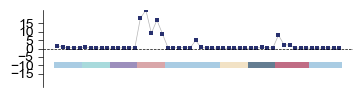

Mouse #10212 Day 2


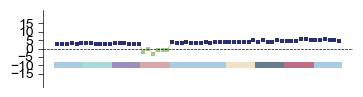

Mouse #10212 Day 3


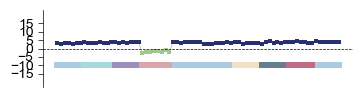

Mouse #10212 Day 4


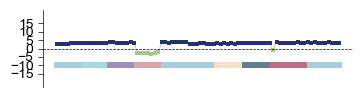

Mouse #10212 Day 5


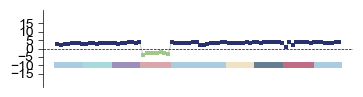

Mouse #10212 Day 6


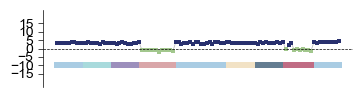

Mouse #10212 Day 7


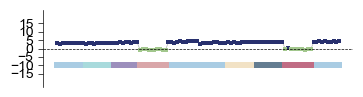

Mouse #10224 Day 1


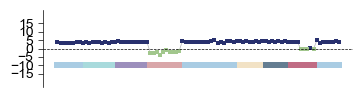

Mouse #10227 Day 1


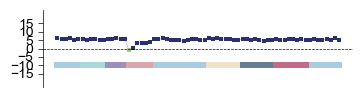

Mouse #10224 Day 2


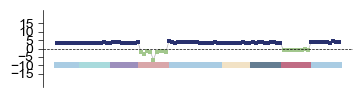

Mouse #10227 Day 2


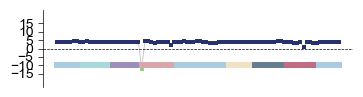

Mouse #10224 Day 3


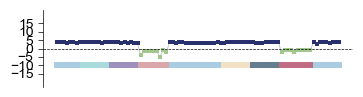

Mouse #10227 Day 3


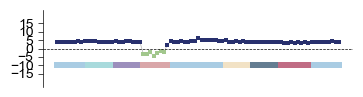

Mouse #10224 Day 4


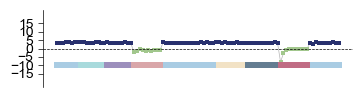

Mouse #10227 Day 4


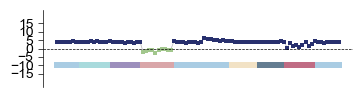

Mouse #10224 Day 5


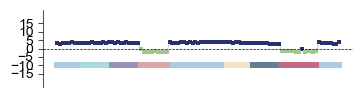

Mouse #10227 Day 5


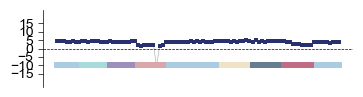

Mouse #10224 Day 6


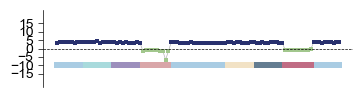

Mouse #10227 Day 6


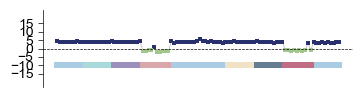

Mouse #10224 Day 7


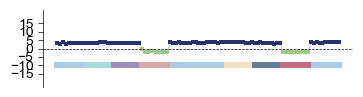

Mouse #10227 Day 7


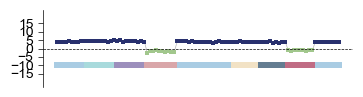

Mouse #10232 Day 1


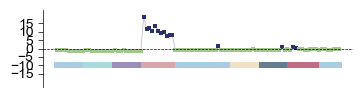

Mouse #10232 Day 2


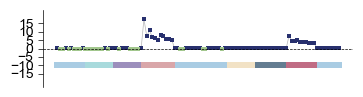

Mouse #10232 Day 3


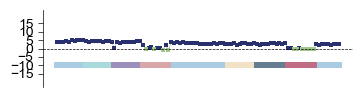

Mouse #10232 Day 4


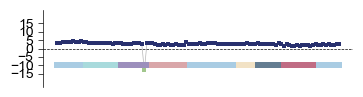

Mouse #10232 Day 5


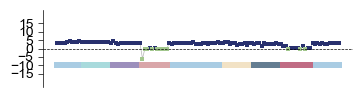

Mouse #10232 Day 6


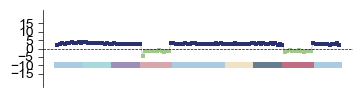

Mouse #10232 Day 7


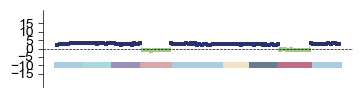

In [5]:
if os.path.exists(join(figdata, code_id+'  [Lapwise Distances].pkl')) == False:
    LapDist = {
        "MiceID": [],
        "Training Day": [],
        "Lap": [],
        "Distance": [],
        "Routes": []
    }
    
    for i in np.where(f2['MiceID'] != 10209)[0]:
        print(f"{i}, {f2['MiceID'][i]}, {f2['training_day'][i]}")
        
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
            
        bins = CP_DSP[3]-1
        #bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])-1
        smoothed_map = get_lapwise_ratemap(trace)[:, bins, :]
        for j in range(smoothed_map.shape[0]):
            smoothed_map[j, :, :] = sklearn.preprocessing.normalize(smoothed_map[j, :, :])
        
        X = smoothed_map = np.transpose(smoothed_map, axes=[2, 1, 0])
        I, J, K = smoothed_map.shape
        
        beg, end = LapSplit(trace, trace['paradigm'])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)

        # Example Usage
        # Generate synthetic tensor X (I x J x K)
        #I, J, K = 100, 10, 12  # Example dimensions
        rank_R = 2             # Number of components
        k_clusters = 2         # Number of clusters
        
        # Factorization with constraints
        dist_score, V, U, UB, _ = low_rank_factorization(X, rank_R, k_clusters)
        print(f"Number of entries < 0: {np.where(V < 0)[0].shape[0]}")
        distances = get_lap_distances(X, V)
        
        LapDist['MiceID'].append(np.repeat(int(f2['MiceID'][i]), distances.shape[0]))
        LapDist['Training Day'].append(np.repeat(f2['training_day'][i], distances.shape[0]))
        LapDist['Lap'].append(np.arange(distances.shape[0]))
        LapDist['Distance'].append(distances)
        LapDist['Routes'].append(routes)
        
    for k in LapDist.keys():
        LapDist[k] = np.concatenate(LapDist[k])
    
    with open(join(figdata, code_id+' [Lapwise Distances].pkl'), 'wb') as handle:
        pickle.dump(LapDist, handle)
        
    print(LapDist['Distance'].shape)
    
    D = pd.DataFrame(LapDist)
    D.to_excel(join(figdata, code_id+' [Lapwise Distances].xlsx'), index=False)
else:
    with open(join(figdata, code_id+' [Lapwise Distances].pkl'), 'rb') as handle:
        LapDist = pickle.load(handle)

dlap = np.ediff1d(LapDist['Lap'])
beg = np.concatenate([[0], np.where(dlap < 0)[0]+1])
end = np.concatenate([np.where(dlap < 0)[0]+1, [LapDist['Lap'].shape[0]]])
print(beg.shape, end.shape)

y_max = np.max(np.abs(LapDist['Distance']))
for i in range(len(beg)):
    beg_idx, end_idx = beg[i], end[i]
    
    print(f"Mouse #{LapDist['MiceID'][beg_idx]} {LapDist['Training Day'][beg_idx]}")
    plt.figure(figsize=(4, 1))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right', 'bottom'], ifyticks=True)
    ax.plot(
        np.arange(end_idx-beg_idx), 
        LapDist['Distance'][beg_idx:end_idx], 
        linewidth=0.5,
        color='#B5B5B6' #gray
    )
    idx0 = np.where(
        LapDist['Distance'][beg_idx:end_idx] > 0
    )[0]
    idx1 = np.where(
        LapDist['Distance'][beg_idx:end_idx] < 0
    )[0]
    ax.plot(
        np.arange(end_idx-beg_idx)[idx0], 
        LapDist['Distance'][beg_idx:end_idx][idx0], 
        's',
        markeredgewidth=0,
        markersize=3.5,
        linewidth=0.5,
        color='#28306E'
    )
    ax.plot(
        np.arange(end_idx-beg_idx)[idx1], 
        LapDist['Distance'][beg_idx:end_idx][idx1], 
        's',
        markeredgewidth=0,
        markersize=3.5,
        linewidth=0.5,
        color='#A2C78D'
    )
    for j in range(7):
        idxr = np.where(LapDist['Routes'][beg_idx:end_idx] == j)[0]
        ax.plot(
            np.arange(end_idx-beg_idx)[idxr], 
            np.repeat(-10, idxr.shape[0]), 
            's',
            markeredgewidth=0,
            markersize=5,
            color=DSPPalette[j]
        )
    
    
    ax.axhline(0, color='k', linewidth=0.5, ls='--')
    ax.set_ylim([-y_max, y_max])
    ax.set_yticks(np.linspace(-15, 15, 7)) 
    plt.show()

# Goodness of Fit

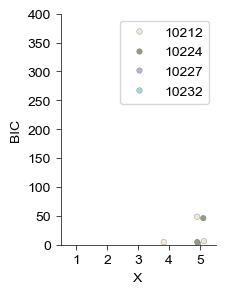

  Mean: -249.86566536759375, STD: 38.4177208748054, Max: -134.12534358786323, Min: -330.79528076245384, Median: -248.79202629528322, df: 27
  Mean: -259.73324455459357, STD: 114.15291299225908, Max: -68.42099505471684, Min: -523.81583377542, Median: -271.55560373872595, df: 27
  Mean: -207.37324965375936, STD: 60.7000307345032, Max: -51.27370734164727, Min: -325.87596737516594, Median: -214.6736644938526, df: 27
TtestResult(statistic=0.5465835272639421, pvalue=0.589153858815562, df=27)
TtestResult(statistic=2.9453923189970452, pvalue=0.006565886536327315, df=27)


In [9]:
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'X',
    y='BIC',
    data=RSSData,
    hue='MiceID',
    palette = ['#F2E8D4', '#8E9F85', '#C3AED6', '#A7D8DE'],
    size = 4,
    linewidth=0.2,
    jitter=0.2,
    ax = ax,
    zorder=1
)
sns.barplot(
    x = 'X',
    y='BIC',
    data=RSSData,
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(0, 400)
#plt.savefig(join(loc, "BIC.png"), dpi=600)
#plt.savefig(join(loc, "BIC.svg"), dpi=600)
plt.show()

idx1 = np.where(RSSData['X'] == 1)[0]
idx2 = np.where(RSSData['X'] == 2)[0]
idx3 = np.where(RSSData['X'] == 3)[0]
print_estimator(RSSData['BIC'][idx1])
print_estimator(RSSData['BIC'][idx2])
print_estimator(RSSData['BIC'][idx3])

print(ttest_rel(RSSData['BIC'][idx1], RSSData['BIC'][idx2]))
print(ttest_rel(RSSData['BIC'][idx3], RSSData['BIC'][idx2]))

# Calculate the frequency of cross-manifold events and its changes over time

100%|██████████| 99/99 [00:00<00:00, 176.15it/s]


[0 1 2 3 4 5 6]


  0%|          | 0/99 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 99/99 [00:01<00:00, 91.87it/s] 


[0 1 2 3 4 5 6]


  0%|          | 0/102 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 102/102 [00:00<00:00, 158.37it/s]


[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:00<00:00, 193.76it/s]


[0 1 2 3 4 5 6]


  0%|          | 0/108 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 108/108 [00:00<00:00, 183.50it/s]


[0 1 2 3 4 5 6]


  0%|          | 0/117 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 117/117 [00:00<00:00, 163.13it/s]


[0 1 2 3 4 5 6]


  0%|          | 0/120 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 120/120 [00:00<00:00, 238.69it/s]


[0 1 2 3 4 5 6]


  0%|          | 0/130 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 130/130 [00:00<00:00, 235.03it/s]


(776, 27, 261)


100%|██████████| 2792/2792 [00:03<00:00, 700.56it/s]


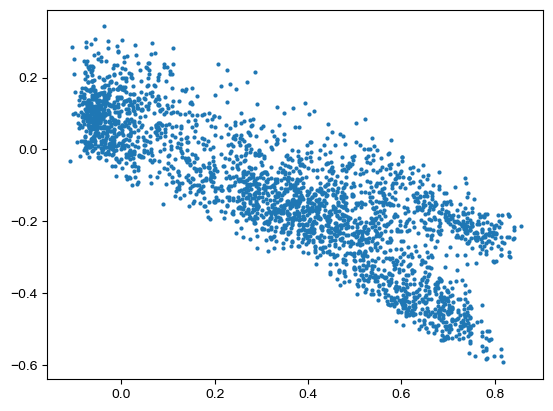

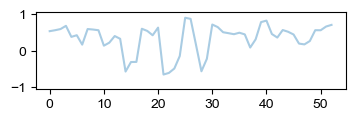

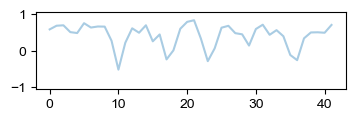

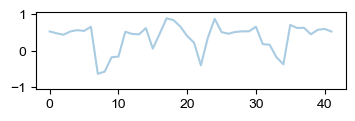

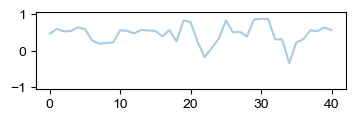

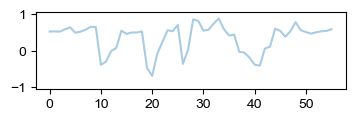

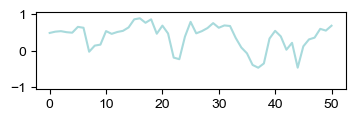

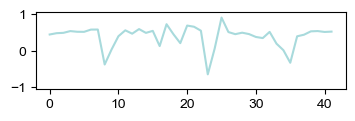

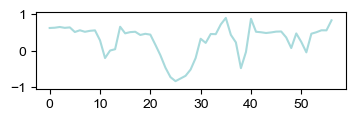

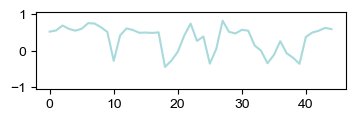

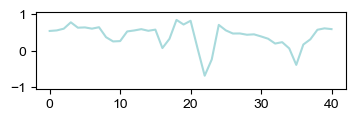

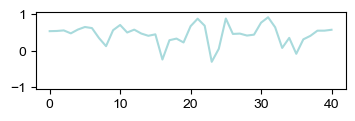

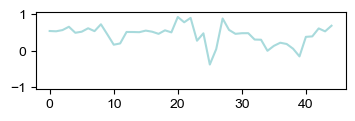

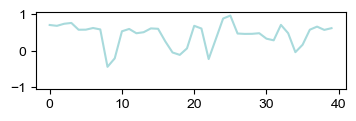

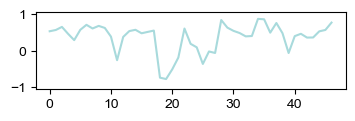

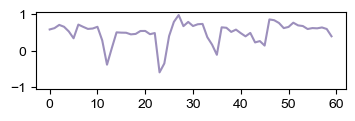

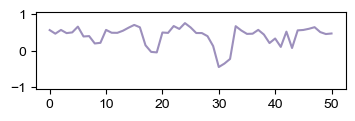

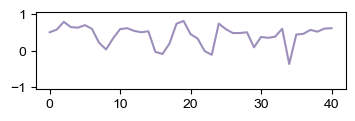

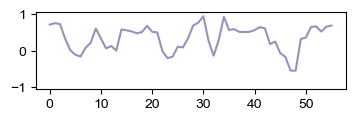

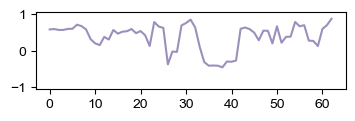

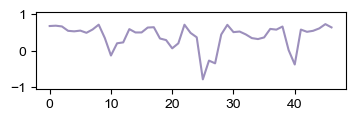

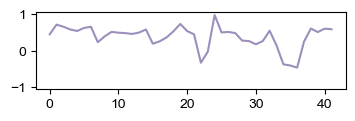

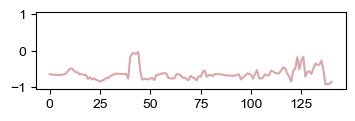

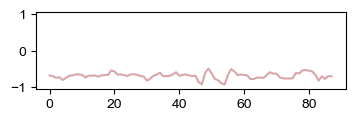

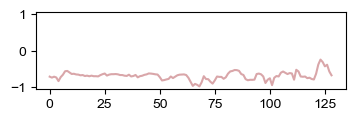

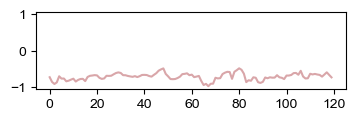

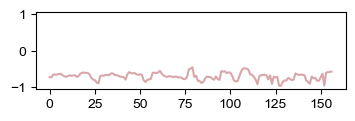

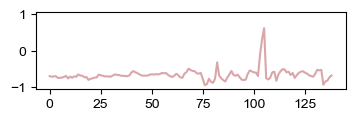

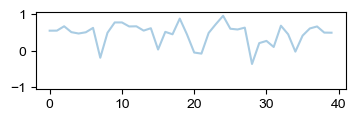

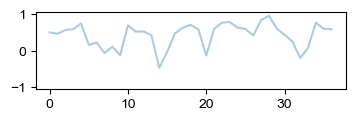

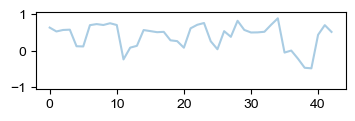

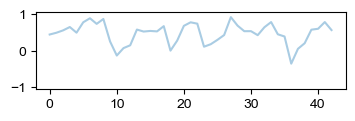

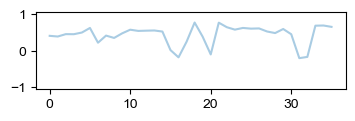

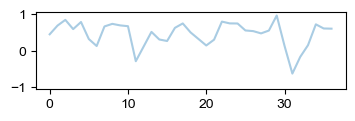

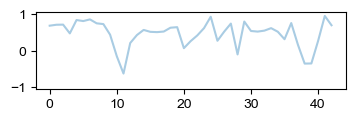

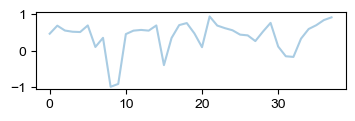

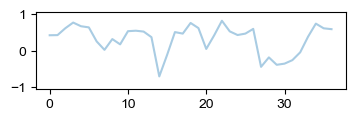

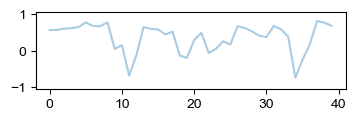

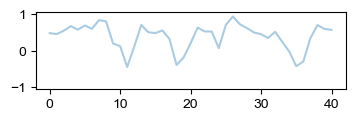

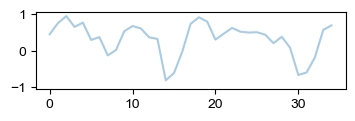

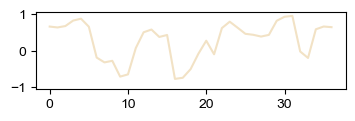

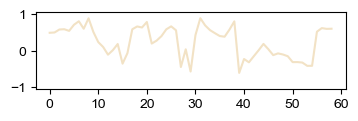

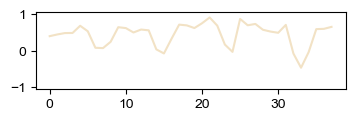

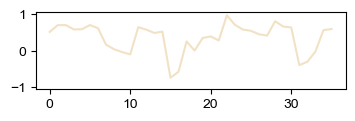

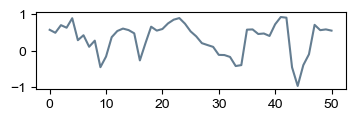

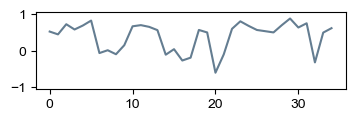

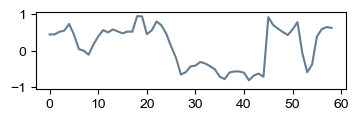

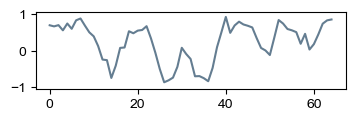

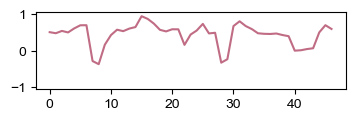

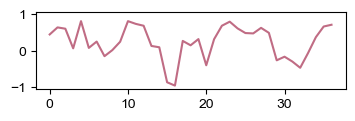

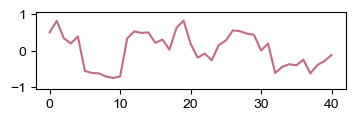

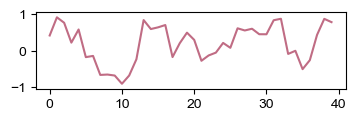

'\nif os.path.exists(join(figdata, code_id+\'.pkl\')) == False:\n    Data = {\n        "MiceID": [],\n        "Training Day": [],\n        "File Index": [],\n        "Lap": [],\n        "Distance": [],\n        "Routes": [],\n        "Dist_Score": [],\n        "Binary Map": []\n    }\n    \n    for i in np.where(f2[\'MiceID\'] != 10209)[0]:\n        print(f"{i}, {f2[\'MiceID\'][i]}, {f2[\'training_day\'][i]}")\n        \n        with open(f2[\'Trace File\'][i], \'rb\') as handle:\n            trace = pickle.load(handle)\n            \n        bins = CP_DSP[3]-1\n        #bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])-1\n        smoothed_map = get_lapwise_ratemap(trace)[:, bins, :]\n        for j in range(smoothed_map.shape[0]):\n            smoothed_map[j, :, :] = sklearn.preprocessing.normalize(smoothed_map[j, :, :], axis=0)\n\n        X = smoothed_map = np.transpose(smoothed_map, axes=[2, 1, 0])\n        I, J, K = smoothed_map.shape\n        \n        beg, end = LapSp

In [45]:
def get_neural_traj(trace: dict):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    
    neural_trajs = []
    pos_trajs = []
    route_trajs = []
    lap_trajs = []
    map_trajs = []
    
    for i in tqdm(range(beg_idx.shape[0])):
        if trace['is_perfect'][i] == 0:
            continue
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        neural_traj = spike_train.calc_neural_trajectory(500, 100)
        neural_traj_vec = neural_traj.to_array()
        pos_traj = neural_traj.variable.to_array()
        
        neural_trajs.append(neural_traj_vec)
        pos_trajs.append(pos_traj)
        route_trajs.append(np.repeat(routes[i], neural_traj_vec.shape[1]).astype(np.int64))
        lap_trajs.append(np.repeat(i, neural_traj_vec.shape[1]).astype(np.int64))
        map_trajs.append(np.repeat(trace['map_cluster'][i], neural_traj_vec.shape[1]))
    
    return np.concatenate(neural_trajs, axis=1), np.concatenate(pos_trajs), np.concatenate(route_trajs), np.concatenate(lap_trajs), np.concatenate(map_trajs)

d = 0
with open(f2['Trace File'][28+d], 'rb') as handle:
    trace = pickle.load(handle)

neural_trajs, pos_trajs, route_trajs, lap_trajs, map_trajs = get_neural_traj(trace)
pos_trajs = spike_nodes_transform(pos_trajs+1, 12)-1
idx = np.where((np.isin(pos_trajs+1, CP_DSP[3])) & (np.isin(route_trajs, [0, 1.,2., 3., 4., 5.,6.])))[0]

neural_trajs = neural_trajs[:, idx]
pos_trajs = pos_trajs[idx]
route_trajs = route_trajs[idx]
lap_trajs = lap_trajs[idx]
map_trajs = map_trajs[idx]
    
rank_R = 5             # Number of components
k_clusters = 2         # Number of clusters
bins = CP_DSP[3]-1
#bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])-1

traces = []
for i in np.where(f2['MiceID'] == 10232)[0]:
    with open(f2['Trace File'][i], 'rb') as handle:
        trace = pickle.load(handle)
    traces.append(trace)

with open(f_CellReg_dsp['cellreg_folder'][4], 'rb') as handle:
    index_map = pickle.load(handle)
    index_map = index_map.astype(np.int64)
    count_map = np.where(index_map > 0, 1, 0)
    sums = np.sum(count_map, axis=0)
    cell_idx = np.where(sums == 7)[0]

smoothed_maps = []
for i, a in enumerate(traces):
    smoothed_map = get_lapwise_ratemap(a)[:, bins, :][index_map[i, cell_idx]-1, :, :]
    for j in range(smoothed_map.shape[0]):
        smoothed_map[j, :, :] = sklearn.preprocessing.normalize(smoothed_map[j, :, :], axis=0)

    smoothed_map = np.transpose(smoothed_map, axes=[2, 1, 0])
    smoothed_maps.append(smoothed_map)

X = smoothed_map = np.concatenate(smoothed_maps, axis=0)
print(X.shape)

I, J, K = smoothed_map.shape
dist_score, V, U, UB, _ = low_rank_factorization(X, rank_R, k_clusters)

VM = V.reshape(V.shape[0], smoothed_map.shape[1], smoothed_map.shape[2])
V = np.zeros((V.shape[0], 144, smoothed_map.shape[2]))
V[:, CP_DSP[3]-1, :] = VM

dist_map_traj = np.zeros((map_trajs.shape[0], 2), np.float64)
for i in tqdm(range(neural_trajs.shape[1])):
    dist1 = pearsonr(neural_trajs[index_map[d, cell_idx]-1, i], V[0, pos_trajs[i], :])[0]
    dist2 = pearsonr(neural_trajs[index_map[d, cell_idx]-1, i], V[1, pos_trajs[i], :])[0]
    
    dist_map_traj[i, :] = np.array([dist1, dist2])

plt.plot(dist_map_traj[:, 0], dist_map_traj[:, 1], 'o', markersize=3, markeredgewidth=0)
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(dist_map_traj)
centroids = kmeans.cluster_centers_

dist1 = np.linalg.norm(dist_map_traj - centroids[:1, :], axis=1)
dist2 = np.linalg.norm(dist_map_traj - centroids[1:, :], axis=1)
dist_traj = (dist1-dist2)/(dist1+dist2)
for i in np.unique(lap_trajs):
    idx = np.where(lap_trajs == i)[0]
    plt.figure(figsize=(4, 1))
    plt.plot(np.arange(idx.shape[0]), dist_traj[idx], color=DSPPalette[route_trajs[idx[0]]])
    plt.ylim(-1.05,1.05)
    plt.show()
"""
if os.path.exists(join(figdata, code_id+'.pkl')) == False:
    Data = {
        "MiceID": [],
        "Training Day": [],
        "File Index": [],
        "Lap": [],
        "Distance": [],
        "Routes": [],
        "Dist_Score": [],
        "Binary Map": []
    }
    
    for i in np.where(f2['MiceID'] != 10209)[0]:
        print(f"{i}, {f2['MiceID'][i]}, {f2['training_day'][i]}")
        
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
            
        bins = CP_DSP[3]-1
        #bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])-1
        smoothed_map = get_lapwise_ratemap(trace)[:, bins, :]
        for j in range(smoothed_map.shape[0]):
            smoothed_map[j, :, :] = sklearn.preprocessing.normalize(smoothed_map[j, :, :], axis=0)

        X = smoothed_map = np.transpose(smoothed_map, axes=[2, 1, 0])
        I, J, K = smoothed_map.shape
        
        beg, end = LapSplit(trace, trace['paradigm'])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)

        # Example Usage
        # Generate synthetic tensor X (I x J x K)
        #I, J, K = 100, 10, 12  # Example dimensions
        rank_R = 2             # Number of components
        k_clusters = 2         # Number of clusters
        
        # Factorization with constraints
        dist_score, V, U, UB, _ = low_rank_factorization(X, rank_R, k_clusters)
        print(dist_score.shape)
        
        Data['MiceID'].append(np.repeat(int(f2['MiceID'][i]), U.shape[0]))
        Data['Training Day'].append(np.repeat(f2['training_day'][i], U.shape[0]))
        Data['File Index'].append(np.repeat(i, U.shape[0]))
        Data['Lap'].append(np.arange(U.shape[0]))
        Data['Distance'].append(U[:, 0])
        Data['Dist_Score'].append(dist_score[:, 0])
        Data['Routes'].append(routes)
        Data['Binary Map'].append(UB)
        
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
    
    with open(join(figdata, code_id+'.pkl'), 'wb') as handle:
        pickle.dump(Data, handle)
        
    print(Data['Distance'].shape)
    
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, code_id+'.xlsx'), index=False)
else:
    with open(join(figdata, code_id+'.pkl'), 'rb') as handle:
        Data = pickle.load(handle)
"""

In [ ]:
for i in range(len(f2)):
    with open(f2['Trace File'][i], 'rb') as handle:
        trace = pickle.load(handle)
        
        bins = CP_DSP[3]-1
        #bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])-1
        smoothed_map = get_lapwise_ratemap(trace)[:, bins, :]
        for j in range(smoothed_map.shape[0]):
            smoothed_map[j, :, :] = sklearn.preprocessing.normalize(smoothed_map[j, :, :], axis=0)

        X = smoothed_map = np.transpose(smoothed_map, axes=[2, 1, 0])
        I, J, K = smoothed_map.shape
        
        beg, end = LapSplit(trace, trace['paradigm'])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)

        # Example Usage
        # Generate synthetic tensor X (I x J x K)
        #I, J, K = 100, 10, 12  # Example dimensions
        rank_R = 2             # Number of components
        k_clusters = 2         # Number of clusters
        
        # Factorization with constraints
        dist_score, V, U, UB, _ = low_rank_factorization(X, rank_R, k_clusters)
    
    trace['map_cluster'] = UB + s1
    
    with open(f2['Trace File'][i], 'wb') as f:
        pickle.dump(trace, f)

[0 1 2 3 4 5 6]


  0%|          | 0/52 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 52/52 [00:00<00:00, 266.31it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/52 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 52/52 [00:00<00:00, 188.17it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/61 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 61/61 [00:00<00:00, 314.76it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/60 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 60/60 [00:00<00:00, 400.78it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/69 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 69/69 [00:00<00:00, 261.59it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/74 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 74/74 [00:00<00:00, 364.41it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/65 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 65/65 [00:00<00:00, 311.23it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/82 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 82/82 [00:00<00:00, 316.60it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/60 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 60/60 [00:00<00:00, 224.52it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/80 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 80/80 [00:00<00:00, 262.86it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/75 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 75/75 [00:00<00:00, 441.28it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/101 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 101/101 [00:00<00:00, 275.17it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/80 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 80/80 [00:00<00:00, 301.81it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:00<00:00, 197.92it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/89 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 89/89 [00:00<00:00, 104.19it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/68 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 68/68 [00:01<00:00, 54.38it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/92 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 92/92 [00:00<00:00, 157.72it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/88 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 88/88 [00:01<00:00, 74.19it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/89 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 89/89 [00:00<00:00, 150.94it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/83 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 83/83 [00:00<00:00, 85.62it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/97 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 97/97 [00:00<00:00, 167.85it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/93 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 93/93 [00:00<00:00, 112.47it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/99 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 99/99 [00:00<00:00, 169.06it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/92 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 92/92 [00:00<00:00, 98.39it/s] 
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:00<00:00, 174.74it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:01<00:00, 95.76it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/101 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 101/101 [00:00<00:00, 188.84it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/95 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 95/95 [00:00<00:00, 123.87it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/99 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 99/99 [00:01<00:00, 90.62it/s] 
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/102 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 102/102 [00:00<00:00, 140.16it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/100 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 100/100 [00:00<00:00, 186.93it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/108 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 108/108 [00:00<00:00, 175.80it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/117 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 117/117 [00:00<00:00, 127.97it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/120 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 120/120 [00:00<00:00, 214.15it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 1 2 3 4 5 6]


  0%|          | 0/130 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 130/130 [00:00<00:00, 243.20it/s]
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [5]:
for i in range(len(f2)):
    print(f2['Trace File'][i])
    with open(f2['Trace File'][i], 'rb') as handle:
        trace = pickle.load(handle)
        
    trace['map_cluster'] = cp.deepcopy(trace['map_custer'])
    del trace['map_custer']
    
    with open(f2['Trace File'][i], 'wb') as f:
        pickle.dump(trace, f)

E:\Data\Dsp_maze\10209\20230524\trace.pkl
E:\Data\Dsp_maze\10212\20230524\trace.pkl
E:\Data\Dsp_maze\10209\20230526\trace.pkl
E:\Data\Dsp_maze\10212\20230526\trace.pkl
E:\Data\Dsp_maze\10209\20230528\trace.pkl
E:\Data\Dsp_maze\10212\20230528\trace.pkl
E:\Data\Dsp_maze\10209\20230529\trace.pkl
E:\Data\Dsp_maze\10212\20230529\trace.pkl
E:\Data\Dsp_maze\10209\20230530\trace.pkl
E:\Data\Dsp_maze\10212\20230530\trace.pkl
E:\Data\Dsp_maze\10209\20230601\trace.pkl
E:\Data\Dsp_maze\10212\20230601\trace.pkl
E:\Data\Dsp_maze\10209\20230602\trace.pkl
E:\Data\Dsp_maze\10212\20230602\trace.pkl
E:\Data\Dsp_maze\10224\20231009\trace.pkl
E:\Data\Dsp_maze\10227\20231009\trace.pkl
E:\Data\Dsp_maze\10224\20231010\trace.pkl
E:\Data\Dsp_maze\10227\20231010\trace.pkl
E:\Data\Dsp_maze\10224\20231011\trace.pkl
E:\Data\Dsp_maze\10227\20231011\trace.pkl
E:\Data\Dsp_maze\10224\20231012\trace.pkl
E:\Data\Dsp_maze\10227\20231012\trace.pkl
E:\Data\Dsp_maze\10224\20231013\trace.pkl
E:\Data\Dsp_maze\10227\20231013\tr